<a href="https://colab.research.google.com/github/Yahia732/Quora-questions-pairs/blob/master/NLP_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
data=pd.read_csv('train.csv')
data = data.dropna(how="any").reset_index(drop=True)

In [ ]:
import gensim
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
from nltk.corpus import stopwords
from tqdm import tqdm_notebook
import nltk
from nltk import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('stopwords')
stop_words = stopwords.words('english')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


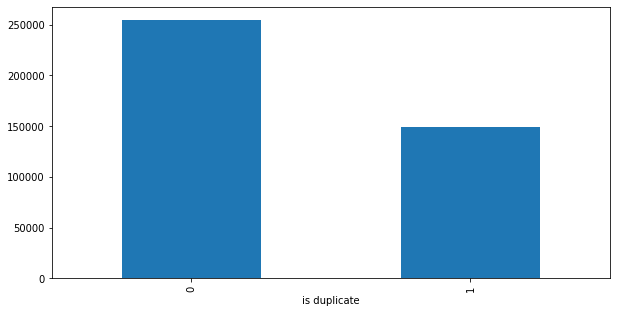

In [ ]:
fig = plt.figure(figsize = (10, 5))
data['is_duplicate'].value_counts().plot(kind='bar') 
plt.xlabel("is duplicate")
plt.show()

In [ ]:
question1=data['question1']
question2=data['question2']

data['freq_qid1'] = data.groupby('qid1')['qid1'].transform('count') 
data['freq_qid2'] = data.groupby('qid2')['qid2'].transform('count')
data['q1len'] = data['question1'].str.len() 
data['q2len'] = data['question2'].str.len()
data['q1_n_words'] = data['question1'].apply(lambda row: len(row.split(" ")))
data['q2_n_words'] = data['question2'].apply(lambda row: len(row.split(" ")))
def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
data['word_Common'] = data.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
data['word_Total'] = data.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
data['word_share'] = data.apply(normalized_word_share, axis=1)

data['freq_q1+q2'] = data['freq_qid1']+data['freq_qid2']
data['freq_q1-q2'] = abs(data['freq_qid1']-data['freq_qid2'])
data.head()    

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [ ]:
import numpy as np
question1=np.array(question1)

In [ ]:
question2=np.array(question2)

In [ ]:
import re


regex = re.compile('[^a-zA-Z" "]')
empty=[""]

In [ ]:
words1=[]
words2=[]
s1=[]
s2=[]
t1=[]
t2=[]
cwc=[]
csc=[]
ctc=[]

nltk.download('punkt')
from nltk.stem import PorterStemmer
ps = PorterStemmer()
for i in range(question1.shape[0]):
    
    question1[i]=regex.sub('',question1[i])
    
    question2[i]=regex.sub('',question2[i])
    
    tmp1=question1[i].lower().split(" ")
    tmp2=question2[i].lower().split(" ")
    #tmp1=word_tokenize(question1[i])
    #tmp2=word_tokenize(question2[i])
    ww1 = set([w for w in tmp1 if w not in stop_words])
    ww2 = set([w for w in tmp2 if w not in stop_words])
    stop1 = set([w for w in tmp1 if w  in stop_words])
    stop2 = set([w for w in tmp2 if w  in stop_words])
    ww1 = set([w for w in ww1 if w not in empty])
    ww2 = set([w for w in ww2 if w not in empty])
    w1=[]
    w2=[]
    for w in ww1:
      
      w=ps.stem(w)
      w1.append(w)
    for w in ww2:
      
      w=ps.stem(w)
      w2.append(w)
    ww1=set(w1)
    ww2=set(w2)
    common_word_count = len(ww1.intersection(ww2))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(stop1.intersection(stop2))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(tmp1).intersection(set(tmp2)))  
    words1.append(ww1)
    words2.append(ww2)
    s1.append(stop1)
    s2.append(stop2)
    t1.append(tmp1)
    t2.append(tmp2)  
    cwc.append(common_word_count)
    csc.append(common_stop_count)
    ctc.append(common_token_count)
  
               

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
delete=[]
for i in range(len(words1)):
  if len(" ".join(words2[i]))<2 or len(" ".join(words1[i]))<2:
    delete.append(i)
  
words1=np.delete(words1,delete)
words2=np.delete(words2,delete)
s1=np.delete(s1,delete)
s2=np.delete(s2,delete)
t1=np.delete(t1,delete)
t2=np.delete(t2,delete)
data.drop(delete,inplace=True) 

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [ ]:
lwe=[]
fwe=[]
diff=[]
mean=[]
cwc_min=[]
cwc_max=[]
csc_min=[]
csc_max=[]
ctc_min=[]
ctc_max=[]

for i in range(len(t1)):
  lwe.append(int(t1[i][-1] == t2[i][-1]))
  fwe.append(int(t1[i][0] == t2[i][0]))
  diff.append(abs(len(t1[i]) - len(t2[i])))
  mean.append((len(t1[i]) + len(t2[i]))/2)
  cwc_min.append(cwc[i] / (min(len(words1[i]), len(words2[i]))))
  cwc_max.append(cwc[i] / (max(len(words1[i]), len(words2[i]))))
  csc_min.append(csc[i] / (min(len(s1[i]), len(s2[i]))+1))
  csc_max.append(csc[i] / (max(len(s1[i]), len(s2[i]))+1))
  ctc_min.append(ctc[i] / (min(len(t1[i]), len(t2[i]))+1))
  ctc_max.append(ctc[i] / (max(len(t1[i]), len(t2[i]))+1))
  


In [ ]:
data['cwc_min'] = cwc_min
data['cwc_max'] = cwc_max
data['csc_min'] = csc_min
data['csc_max'] = csc_max
data['ctc_min'] = ctc_min
data['ctc_max'] = ctc_max
# Last word of both question is same or not
data["last_word_eq"] = lwe
# First word of both question is same or not
data["first_word_eq"] = fwe
data["abs_len_diff"] = diff
#Average Token Length of both Questions
data["mean_len"] = mean


In [ ]:
words1=np.array(words1)
words2=np.array(words2)

In [ ]:
data['words1']=words1
data['words2']=words2
data['stops1']=s1
data['stops2']=s2
data['Tokens1']=t1
data['Tokens2']=t2

In [ ]:
data = data.dropna(how="any").reset_index(drop=True)

In [ ]:
words1=data['words1']
words2=data['words2']
s1=data['stops1']
s2=data['stops2']
t1=data['Tokens1']
t2=data['Tokens2']
words1=np.array(words1)
words2=np.array(words2)
s1=np.array(s1)
s2=np.array(s2)
t1=np.array(t1)
t2=np.array(t2)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vector=[]

import warnings 
warnings.filterwarnings(action = 'ignore')
from sklearn.feature_extraction.text import CountVectorizer
for i in range(words1.shape[0]):
  
  try:
      
      corpus=[" ".join(words1[i])," ".join(words2[i])]
      cv=TfidfVectorizer()
      x=cv.fit_transform(corpus)
      
  except:
    print(i) 
  vector.append(pd.DataFrame(x.toarray(),columns=cv.get_feature_names()))

In [ ]:
f_vec=[]
s_vec=[]

In [ ]:
for i in range (len(vector)):
  f_vec.append(vector[i].iloc[0])
  s_vec.append(vector[i].iloc[1])

In [ ]:
print(s_vec[0])
print(f_vec[0])

guid      0.447214
india     0.000000
invest    0.447214
market    0.447214
share     0.447214
step      0.447214
Name: 1, dtype: float64
guid      0.378632
india     0.532154
invest    0.378632
market    0.378632
share     0.378632
step      0.378632
Name: 0, dtype: float64


In [ ]:
data['tf idf1']=f_vec
data['tf idf2']=s_vec

In [ ]:
from numpy import dot
from numpy.linalg import norm
similar=[]

for i in range(len(f_vec)):

   result = dot(f_vec[i],s_vec[i])/(norm(f_vec[i])*norm(s_vec[i]))
   similar.append(result)
   


In [ ]:
data['Cosine_similarity']=similar


In [ ]:
data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len', 'words1',
       'words2', 'stops1', 'stops2', 'Tokens1', 'Tokens2', 'tf idf1',
       'tf idf2', 'Cosine_similarity'],
      dtype='object')

In [ ]:
data = data.dropna(how="any").reset_index(drop=True)

In [ ]:
features=[ 
        
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len','Cosine_similarity']

In [ ]:

x=data[features]
Y=data['is_duplicate']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
...     x, Y,shuffle=True)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import pickle
y_train=np.array(y_train)
y_test=np.array(y_test)
X_train=np.array(X_train)
X_test=np.array(X_test)
# X_train=X_train.reshape(X_train.shape[0],1)
# y_train=y_train.reshape(y_train.shape[0],1)
# X_test=X_test.reshape(X_test.shape[0],1)
# y_test=y_test.reshape(y_test.shape[0],1)
# Cls = SVC(kernel='linear', C=0.8)
# Cls.fit(X_train,y_train)
# predction1=Cls.predict(X_train)
# print ('SVM Training accuracy')
# print(metrics.accuracy_score(predction1,y_train))
# predction2=Cls.predict(X_test)
# print('SVM Testing accuracy')
# print(metrics.accuracy_score(predction2,y_test))

In [ ]:
XG=XGBClassifier(n_estimators=35,max_depth=12)
XG.fit(X_train,y_train)

XGBClassifier(max_depth=12, n_estimators=35)

In [ ]:
predction1=XG.predict(X_train)
print('XGBoost Training accuracy')
print(metrics.accuracy_score(predction1,y_train))
print('XGBoost Testing accracy')
predction2=XG.predict(X_test)
print(metrics.accuracy_score(predction2,y_test))

XGBoost Training accuracy
0.8461815181518152
XGBoost Testing accracy
0.8207146463896398


In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF =RandomForestClassifier(n_estimators = 35,max_depth=12)
RF.fit(X_train,y_train)
predction1=RF.predict(X_train)
print('Random Forest Training accuracy')
print(metrics.accuracy_score(predction1,y_train))
predction2=RF.predict(X_test)
print('Random Forest testing accuracy')
print(metrics.accuracy_score(predction2,y_test))

Random Forest Training accuracy
0.8287986798679868
Random Forest testing accuracy
0.8160513262244928


In [ ]:
DT = DecisionTreeClassifier(random_state=0,max_depth=12)
DT.fit(X_train,y_train)
predction1=DT.predict(X_train)
print('Decision Tree Training accuracy')
print(metrics.accuracy_score(predction1,y_train))
predction2=DT.predict(X_test)
print('Decision Tree testing accuracy')
print(metrics.accuracy_score(predction2,y_test))

Decision Tree Training accuracy
0.8263927392739274
Decision Tree testing accuracy
0.8106850427223493


In [ ]:
LR=LogisticRegression(random_state=0).fit(X_train, y_train)
predction1=LR.predict(X_train)
print('Logistic Regression  Training accuracy')
print(metrics.accuracy_score(predction1,y_train))
predction2=LR.predict(X_test)
print('Logistic Regression testing accuracy')
print(metrics.accuracy_score(predction2,y_test))


Logistic Regression  Training accuracy
0.7695940594059406
Logistic Regression testing accuracy
0.7710022673042841


In [ ]:
NB = GaussianNB()
NB.fit(X_train, y_train)
predction1=NB.predict(X_train)
print('Naive Bayes Training accuracy')
print(metrics.accuracy_score(predction1,y_train))
predction2=NB.predict(X_test)
print('Naive Bayes testing accuracy')
print(metrics.accuracy_score(predction2,y_test))


Naive Bayes Training accuracy
0.7281584158415841
Naive Bayes testing accuracy
0.7295967366659736


In [ ]:
predction_xg=XG.predict(X_test)
predction_dt=DT.predict(X_test)
predction_nb=NB.predict(X_test)
predction_lr=LR.predict(X_test)
predction_rf=RF.predict(X_test)

In [ ]:
xg_acc=metrics.accuracy_score(predction_xg,y_test)
dt_acc=metrics.accuracy_score(predction_dt,y_test)
nb_acc=metrics.accuracy_score(predction_nb,y_test)
lr_acc=metrics.accuracy_score(predction_lr,y_test)
rf_acc=metrics.accuracy_score(predction_rf,y_test)

In [ ]:

#Dict={'svm':svm_acc,'XGBoost':xg_acc,'Decision Tree':dt_acc,'Naive Bayes':nb_acc,'Logistic Regression':lr_acc}
models=['Random Forest','XGBoost','Decision Tree','Naive Bayes','Logistic Regression']
Accuracies=[rf_acc,xg_acc,dt_acc,nb_acc,lr_acc]

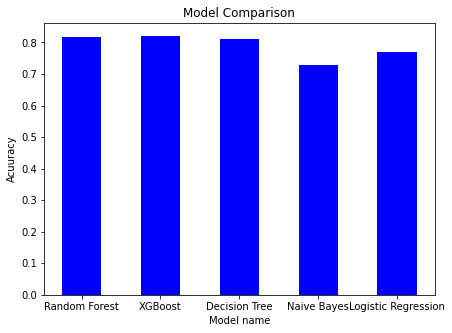

In [ ]:
fig = plt.figure(figsize = (7, 5))
 
# creating the bar plot
plt.bar(models, Accuracies, color ='blue',
        width = 0.5)
 
plt.xlabel("Model name")
plt.ylabel('Acuuracy')
plt.title("Model Comparison")
plt.show()

In [ ]:
data.to_csv('Quora questions')